In [2]:


from utils import Photo, Turbine, pull_street_view_image, object_to_image, calc_angle_dist, is_in_frame, transform_coordinates, generate_visual_impact_old, adjust_image
import requests
import numpy as np
from io import BytesIO
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from pyproj import Geod
from PIL import Image, ImageDraw, ImageEnhance

Defining function to pull images from the Google Street View API.

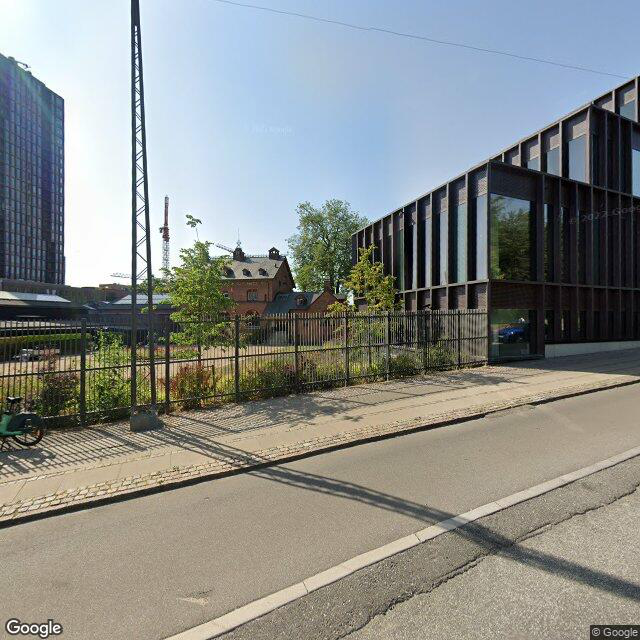

In [61]:
with open("../assets/API.txt", 'r') as file:
    api_key = file.read().strip()

longitude = 12.5298105
latitude = 55.6675831


pull_street_view_image(api_key, longitude, latitude, fov = 90, heading = 180, pitch = 0, width = 400, height = 400)

Test function

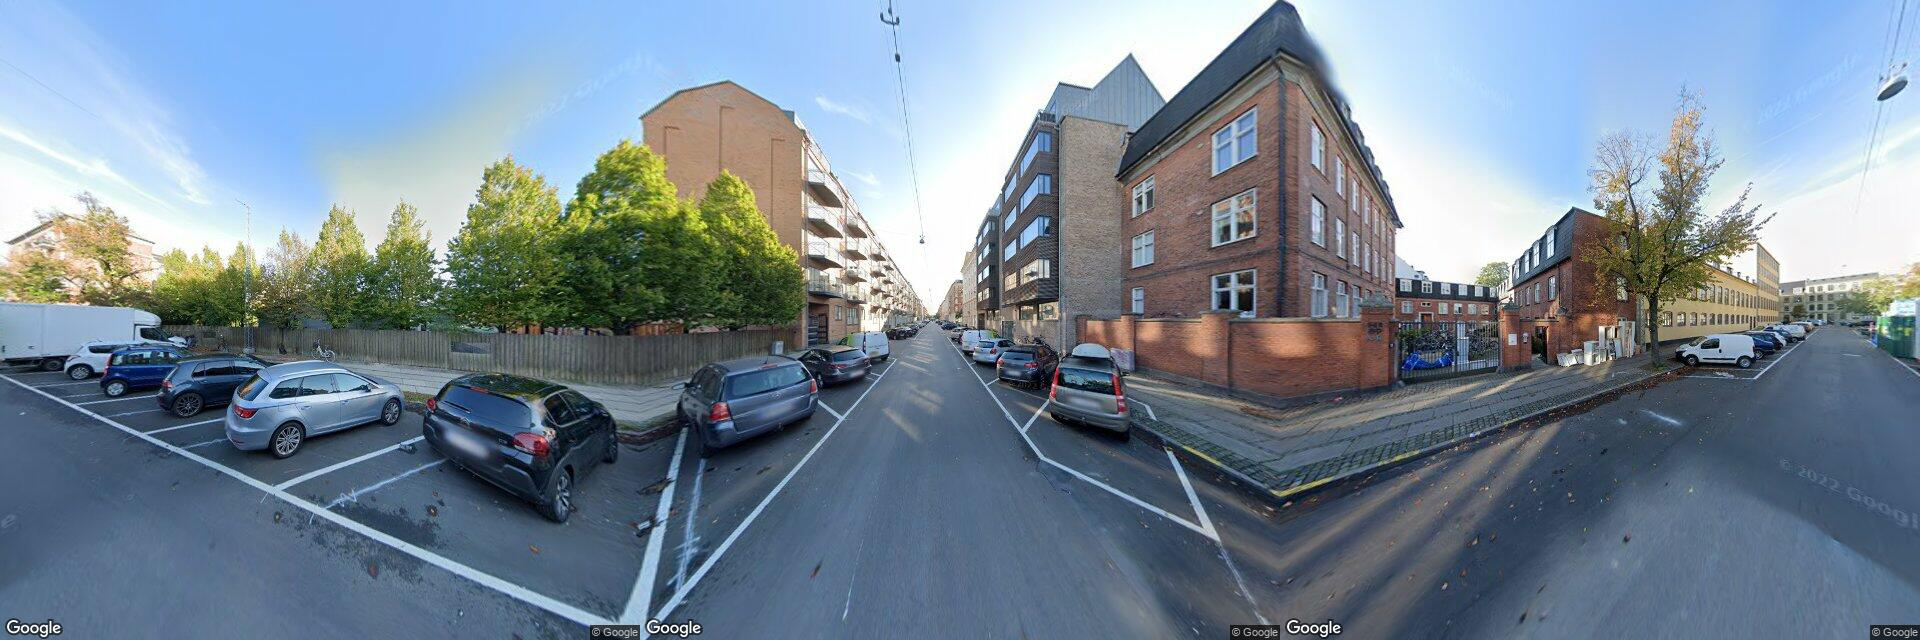

In [4]:
fov = 120
headings = np.arange(0, 360, fov)
image_list = []
for heading in headings:
    new_image = pull_street_view_image(api_key, longitude, latitude, heading=heading, fov = fov)
    
    # Append the new image to the list
    image_list.append(new_image)

# Calculate the total width needed for the final image
total_width = sum([img.width for img in image_list])
max_height = max([img.height for img in image_list])

# Create a blank canvas for the final image
final_image = Image.new('RGB', (total_width, max_height))

# Paste each image onto the final image
x_offset = 0
for img in image_list:
    final_image.paste(img, (x_offset, 0))
    x_offset += img.width

# Display or save the final image
display(final_image)



For later use: https://maps.googleapis.com/maps/api/streetview/metadata?size=600x300&location=eiffel%20tower,%20paris,%20france&heading=-45&pitch=42&fov=110&key=YOUR_API_KEY&signature=YOUR_SIGNATURE


In [6]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Initialize Google Street View image
focal_length = 0.02
fov = 90
direction = 0 # direction [deg]
tilt = 0 # vertical tilt [deg]
# cord_pic = [12.57738264699112, 55.70864662616602]
coord_pic = [12.530035398113766, 55.66769631625086]
# 55.66769631625086, 12.530035398113766

pull_street_view_image(api_key, coord_pic[0], coord_pic[1], fov = fov, heading = direction, pitch = 0, width = 400, height = 400)
long_pic, lat_pic = transform_coordinates(coord_pic[0], coord_pic[1], input_crs_str = "EPSG:4326", output_crs_str = "EPSG:3035")[0,0]
# loc_pic = np.array([long_pic, lat_pic, 2])
loc_pic = np.array([0, 0, 0])
pic = Photo("../temp/site_img.png", fov, tilt, direction, coord_pic, loc_pic, focal_length)

# Initialize Turbine
coord_turb = [12.533434441656016, 55.66534279150843]
wind_dir = 0 # 
height = 100
angle, distance = calc_angle_dist(coord_pic, coord_turb)
# pil_image = object_to_image("../assets/windmill.obj", elevation = 0, azimuth = 270)
# adjust_image(pil_image, 1, 1)
# cord_turb = [12.577497179673044, 55.70445262086221]

print(angle, distance)

long_turb, lat_turb = transform_coordinates(coord_turb[0], coord_turb[1], input_crs_str = "EPSG:4326", output_crs_str = "EPSG:3035")[0,0]
# loc_turb = np.array([long_turb, lat_turb, 2])
loc_turb = np.array([1000, 0, 0])
turb = Turbine("../temp/obj2png.png", fov, height, coord_turb, loc_turb, wind_dir)
vis_impact_im = generate_visual_impact_old(pic, turb)
display(vis_impact_im)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
140.77357456204174 338.2498249627892


TypeError: camera_matrix() takes 2 positional arguments but 3 were given

[2.00013882e+06 5.45292593e+02 2.00919854e+05]
[1.99986118e+06 5.45292593e+02 2.01080146e+05]
[1.99986118e+06 2.00000000e+00 2.01080146e+05]
[2.00013882e+06 2.00000000e+00 2.00919854e+05]


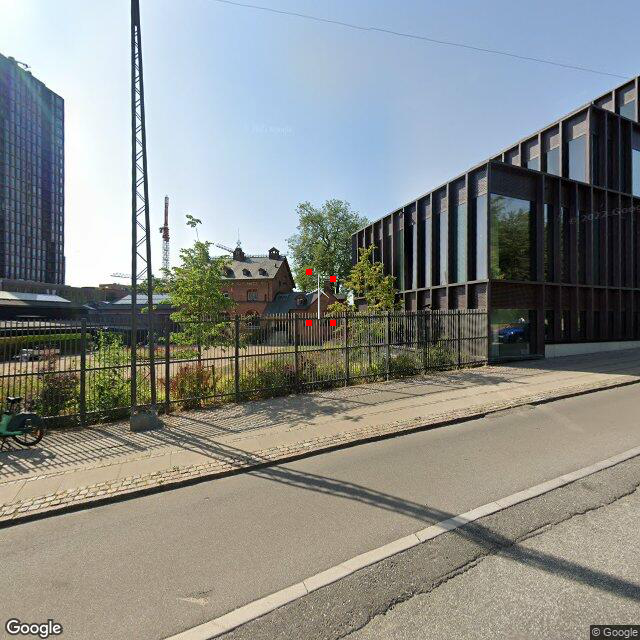

In [70]:
from utils import camera_matrix, find_coeffs
direction = np.deg2rad(-30)
loc_pic = np.array([2000000, 2, 200000])
loc_turb = np.array([2000000, 2, 201000])

picture1 = Photo("../temp/site_img.png", fov, tilt, direction, coord_pic, loc_pic, focal_length)
turbine1 = Turbine("../temp/obj2png.png", fov, height, coord_turb, loc_turb, wind_dir)
location1 = loc_pic
location2 = loc_turb


radius = turbine1.radius

draw = ImageDraw.Draw(picture1.im)

point1 = np.array([np.cos(direction)*radius, height+radius, np.sin(direction)*radius])+location2
point2 = -np.array([np.cos(direction)*radius, -height-radius, np.sin(direction)*radius])+location2
point3 = -np.array([np.cos(direction)*radius, 0, np.sin(direction)*radius])+location2
point4 = np.array([np.cos(direction)*radius, 0, np.sin(direction)*radius])+location2

p_list = [point1, point2, point3, point4]
pa = []
for p in p_list:
    print(p)
    q = camera_matrix(picture1, p)
    d = draw.rectangle(((q[0],q[1]),(q[0]+5,q[1]+5)),fill = "red")
    pa.append([q[0],q[1]])
    

pc = np.array(pa).reshape(4,2)
pc[:,0] -= np.amin(pc[:,0])
pc[:,1] -= np.amin(pc[:,1])

pb = [(0, 0), (turbine1.shape[1], 0), (turbine1.shape[1], turbine1.shape[0]), (0, turbine1.shape[0])]

scale_x = np.amax(np.array(pb).reshape(4,2)[:,0])/np.amax(pc[:,0])
scale_y = np.amax(np.array(pb).reshape(4,2)[:,1])/np.amax(pc[:,1])

pd = list(pa)
for i in range(len(pa)):
    pa[i] = [pc[i,0],pc[i,1]]
    

coeffs = find_coeffs(pa, pb)

width, height = turbine1.im.size 
turbine1.im = turbine1.im.transform((int(np.amax(np.array(pa).reshape(4,2)[:,0])),int(np.amax(np.array(pa).reshape(4,2)[:,1]))), method=Image.Transform.PERSPECTIVE,data=coeffs)

picture1.im.paste(turbine1.im, box=[np.amin(np.array(pd).reshape(4,2)[:,0]).astype(int),np.amin(np.array(pd).reshape(4,2)[:,1]).astype(int)], mask = turbine1.im)
picture1.im.show()
display(picture1.im)

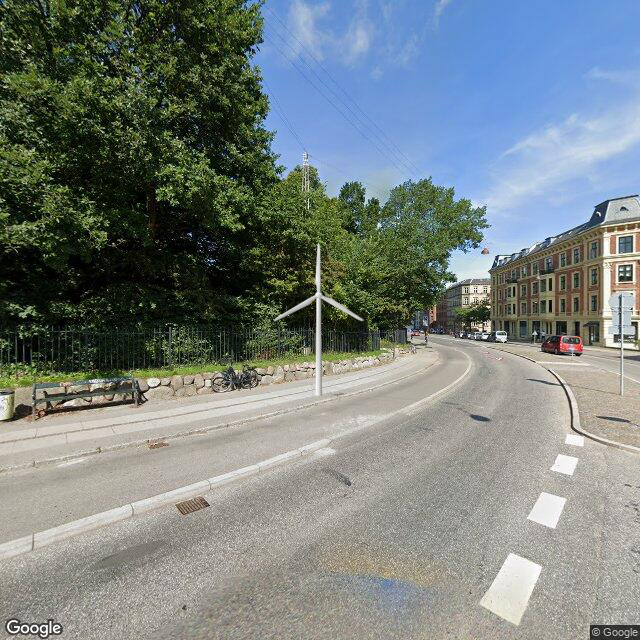

In [60]:
from PIL import Image
import math
import numpy as np

# Input image 
img = Image.open("../temp/site_img.png")
width, height = img.size

# Image properties
fov = 150 # Field of view in degrees
view_dir = np.array([0, 0, 0]) # View direction vector

# Object to insert
obj_coord = np.array([0, 0, 100]) # Object 3D coordinates 
obj_height = 5 # Object height
obj_img = Image.open("../temp/obj2png.png")
obj_width, obj_height = obj_img.size

# Calculate projection
proj_scale = fov / (obj_coord[2] * math.tan(math.radians(fov / 2)))
proj_x = obj_coord[0] * proj_scale + width/2
proj_y = -obj_coord[1] * proj_scale + height/2 

# Calculate rotation
rotation_matrix = np.identity(3)
rotation_matrix = rotation_matrix.dot(np.array([
    [math.cos(math.atan2(view_dir[2], view_dir[0])), 0, math.sin(math.atan2(view_dir[2], view_dir[0]))],
    [0, 1, 0], 
    [-math.sin(math.atan2(view_dir[2], view_dir[0])), 0, math.cos(math.atan2(view_dir[2], view_dir[0]))]
]))
obj_img = obj_img.rotate(math.degrees(math.atan2(view_dir[1], view_dir[0])))

# Scale object
proj_width = obj_width * proj_scale
proj_height = obj_height * proj_scale
proj_img = obj_img.resize((int(proj_width), int(proj_height)))

# Paste onto image
img.paste(proj_img, (int(proj_x-proj_width/2), int(proj_y-proj_height/2)), proj_img)

display(img)